# Using Machine Learning Algorithm Dispatching to Automate Model Evaluation and Reduce Code Duplication

## How to build an object-oriented algorithm dispatcher to speed up and automate the model evaluation stage of the machine learning pipeline, keep code tidy and reduce code duplication


Photo by <a href="https://unsplash.com/@afgprogrammer?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Mohammad Rahmani</a> on <a href="https://unsplash.com/s/photos/code?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### 1. Introduction

One of the stages of the machine learning pipeline is model evaluation. This is where a data scientist will try out different types of machine learning algorithm, typically early on in the data science pipeline, to see which once show the most promise.

This will typically lead to selection of one, or a few, algorithms to move forward through the process leading to the eventual final solution.

### 2. Getting Started

Lets start by importing the libraries we will need and by setting some display configuration so that our output is more readable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, HTML

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import KFold, cross_val_score

pd.set_option('max_colwidth', 500)

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

We will also need some test data which has been taken from https://www.kaggle.com/c/credit-default-prediction-ai-big-data/overview.

Note: the raw data has been modified by replacing nulls with median values and then one-hot encoding the categorical features so that it is in a good state to feed into a machine learning algorithm.

In [3]:
df_credit_prepared = pd.read_csv("train_prepared.csv")

X = df_credit_prepared.drop('Credit Default', axis=1)
y = df_credit_prepared['Credit Default']

### 3. The Problem

Historically I have seen code examples online where a range of ML algorithms are selected by the data scientist and then hard coded into a solution -

In [4]:
models = []
models.append(('LR', LogisticRegression(random_state=42))) # Logistic Regression
models.append(('LDA', LinearDiscriminantAnalysis())) # Linear Discriminant Analysis
models.append(('XGB', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))) # Linear Discriminant Analysis
models.append(('CAT', CatBoostClassifier(silent=True, random_state=42))) # Linear Discriminant Analysis
models.append(('KNN', KNeighborsClassifier())) # K-Nearest Neighbors
models.append(('CART', DecisionTreeClassifier(random_state=42))) # Decision Tree
models.append(('SVM', SVC(probability=True, random_state=42))) # Support Vector Machine

Once the models have been selected and instantiated, we can write some helper functions and then fit and evaluate the models ...

In [5]:
def fit_models(models, X, y):
    for _, model in models:
        model.fit(X, y)

def evaluate_models(models, X_train, y_train, scoring="accuracy"):
    results = []
    names = []

    for name, model in models:
        kfold = KFold(n_splits=5, random_state=42, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append((name, cv_results))
        
    return np.array(results, dtype=object)
        
def plot_model_results(results, title):
    unpack_names = results[:,0]
    unpack_results = results[:,1]

    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(unpack_results)
    ax.set_xticklabels(unpack_names, rotation='vertical')
    fig.set_size_inches(8,6)
    plt.show()

We can now execute the helper functions to fit, evaluate and visualise the relative performance of the algorithms ,,,

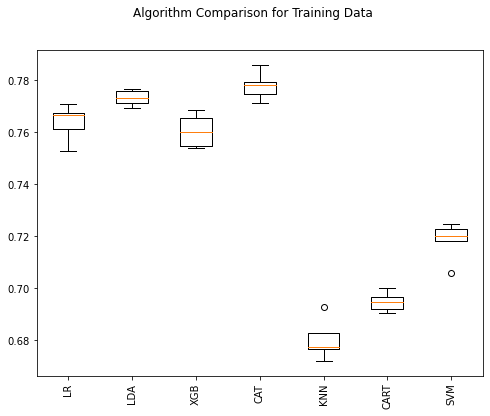

In [17]:
fit_models(models, X, y)
results_train = evaluate_models(models, X, y)
plot_model_results(results_train, 'Algorithm Comparison for Training Data')

Based on these results we would be interested in selecting the linear regrssion, linear discriminant analysis, XG Boost and Cat Boost algorithms to move forward into more detailed analysis and optimisation.

These algorithms have the highest accuracy and the lowest variance so perfomance on test and live data is likely to be accurate and consistent.

Note: to keep the example simple we will drop LDA and keep the other 3.

### 4. Improving the Solution

Everything that has been done so far is reasonable. We have selected some algorithms to evaluate against the data, used cross fold validation to minimise the possibility of over-fitting, visualised the results and made a well reasoned selection of our 2 candidate algorithms.

However the solution can be improved by using the "algorithm dispatcher" pattern. This approach takes the algorithms out of the hard coding of the notebook and moves them into meta data and this means that should we want to re-run this stage with a different set of algorithms, all we need to do is to change the meta-data and then click the run button.

Here is how it works ...

#### 4.1 Setup

The first step is to create an excel spreadsheet that contain the meta-data we are going to use to select, instantiate and execute our algorithms. 

Here is an example of some meta-data that will drive the dispatcher pattern -

In [9]:
df_models_meta_data = pd.read_excel("credit_models.xlsx")
pretty_print(df_models_meta_data)

In the example meta-data I have defined 3 models that are going to be used. Here is the explanation for each of the fields in the meta data ...

In [10]:
df_meta_data_description = pd.read_excel("credit_models.xlsx", sheet_name="Sheet2")
pretty_print(df_meta_data_description)

#### 4.2 Model Dispatcher Class

``ModelDispatcher`` and ``Model`` classed can now be written to instantiate and use the algorithms defined in the meta data -

In [11]:
class ModelDispatcher():
    """The ModelDispatcher class reads Python program code from data in a spreadsheet to create a range of machine learning algorithms dynamically
        """
    
    def __init__(self, filepath, random_state=42):
        """Constructor

            Args:
                filepath (str, optional): The path the the Excel file containing the parameters.
                random_state (int, optional): The random state to be passed into the algorithms. Defaults to 42.
            """
        self.models = dict()

        df_models = pd.read_excel(filepath, index_col="name") 

        for index, row in df_models.iterrows():
            self.models[index] = Model(row, index, random_state=random_state)

class Model():
    """The Model class is instantiated to represent each of the models defined in the meta data
        """

    def __init__(self, row, name, random_state=42):

        self._row = row
        self.random_state = random_state

        self.name = name

        exec(self._row["execute_setup"])
    
    @property
    def algorithm_hyperparams(self):
        exec(self._row["algorithm_hyperparams"])
        return self._algorithm_hyperparams

    @property
    def algorithm(self):
        exec(self._row["algorithm"])
        self._algorithm.set_params(**self.algorithm_hyperparams)
        return self._algorithm

    @property
    def search_space(self):
        exec(self._row["search_space"])
        return self._search_space


The two classes defined are pretty simple. ``ModelDispatcher`` just opens the meta-data file and iterates over the rows creating a list of type ``Model`` for each row in the meta-data.

The ``Model`` class reads in the meta-data for a single row and executes the code using the built in Python ``exec`` function.

Any code found in ``execute_setup`` is executed as the class is instantiated. The ``algorithm`` property is executed when the algorithm is accessed as are ``algorithm_hyperparameters`` and ``search_space``.

It is more easily explained in an example, so here goes ..

#### 4.2 Implementation

The hard-coding in the original solution will now be replaced by dynamic calls to our new classes as follows ...

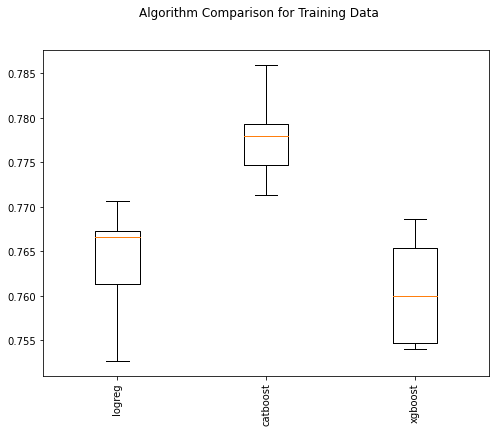

In [19]:
dispatcher = ModelDispatcher(filepath="credit_models.xlsx", random_state=42)

results = []

for model in dispatcher.models.values():
    model.algorithm.fit(X, y)
   
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model.algorithm, X, y, cv=kfold, scoring="accuracy")
    results.append((model.name, cv_results))
    
plot_model_results(np.array(results, dtype=object), 'Algorithm Comparison for Training Data')  

And if you would like to select a single model from the dispatcher, that can be done as follows ...

In [16]:
my_model = dispatcher.models["logreg"]
my_model.algorithm

LogisticRegression(max_iter=10000, penalty='none', random_state=42)

### 5. Conclusion

We have explored how to get rid of the hard-coding of multiple machine learning algorithms in a Jupyter Notebook or other Python  code and replace it with a call to an instance of a ``ModelDispatcher`` class.

In the example we replaced the code to fit, evaluate and display the relative performance of 3 algorithms with the dispatcher pattern using meta-data in a spreadsheet and explored how we could simply add or modify the spreadsheet and re-run the code to add new algorithms or to change some parameters.

The example was slightly contrived to fit it into a few minutes of reading and you may be asking if the dispatcher and meta-data is significantly better than the hard coding.

I have written many ML solutions where I have started writing a different Jupyter Notebook for each of my candidate algorithms. They start off the same but over time duplicate code will get out of step and this is where the dispatcher pattern really comes in.

You can write a single Jupyter Notebook for each stage of the data science pipeline and then just pass in a different key to select a different algorithm and the Notebook code will always be clean and consistent and you will avoid duplication and versioning issues.

## Thank you for reading!
If you enjoyed reading this article, why not check out my other articles at https://grahamharrison-86487.medium.com/?

Also, I would love to hear from you to get your thoughts on this piece, any of my other articles or anything else related to data science and data analytics.

If you would like to get in touch to discuss any of these topics please look me up on LinkedIn — https://www.linkedin.com/in/grahamharrison1 or feel free to e-mail me at GHarrison@lincolncollege.ac.uk.